## Preparation
In this section, packages will be imported and the random seed will be set.


In [2]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D
from matplotlib import cm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 200

In [3]:
#some parameters set to make graphs nicer
plt.style.use('default')
#
# plt.rcParams['axes.facecolor'] = 'none'
#plt.rcParams['axes.grid'] = True
# plt.rcParams['figure.frameon'] = True
#
plt.rcParams['grid.color'] = '#000000'
plt

rs = 290310
np.random.seed(rs)

## Ex.1 Loading and Preparing the Data
In this section, the data will be loaded into the project and will be manipulated into a manageble format for our analysis

In [4]:
df_path = 'data\cla4lsp22_bikez_curated.csv'
df_tot = pd.read_csv(df_path)
r = np.random.randint(0,3)
workdf = df_tot.loc[df_tot['Year']%3 == r]

In [5]:
feature_to_remove = ['Front brakes', 'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension', 'Rear suspension']

feature_to_remove = np.random.choice(feature_to_remove, size=2, replace = False)

workdf.drop(columns=feature_to_remove, axis = 1, inplace=True)

print('Columns', feature_to_remove, 'have been dropped from the DataFrame')

display(workdf)

Columns ['Rear tire' 'Front suspension'] have been dropped from the DataFrame


Brand                   Model  Year                   Category   
1      acabion                 gtbo 55  2007                      Sport  \
4      acabion                 gtbo 70  2007  Prototype / concept model   
6       access     ams 3.20 supercross  2016                        ATV   
7       access  ams 4.30 supermoto efi  2016                        ATV   
8       access  ams 4.38 sm gear shift  2016                        ATV   
...        ...                     ...   ...                        ...   
38459  zündapp            roller super  1968                    Scooter   
38462  zündapp                   z 2 g  1923                      Sport   
38466  zündapp                    z 22  1923                      Sport   
38468  zündapp                   z 249  1923                      Sport   
38471  zündapp                   z 300  1929                      Sport   

       Rating  Displacement (ccm)  Power (hp)  Torque (Nm)  Engine cylinder   
1         2.6              1300.0       541.0        420.0     In-line four  \
4         3.1              1300.0       689.0        490.0     In-line four   
6         NaN               280.0        18.8          NaN  Single cylinder   
7         NaN               359.3        29.5          NaN  Single cylinder   
8         NaN               449.0        37.6          NaN  Single cylinder   
...       ...                 ...         ...          ...              ...   
38459     NaN                49.0         NaN          NaN  Single cylinder   
38462     NaN               211.0         2.8          NaN  Single cylinder   
38466     NaN               211.0         2.3          NaN  Single cylinder   
38468     NaN               249.0         2.8          NaN  Single cylinder   
38471     NaN               298.0        26.0          NaN  Single cylinder   

      Engine stroke            Gearbox  Bore (mm)  Stroke (mm)   
1       four-stroke            6-speed       81.0         63.0  \
4       four-stroke            6-speed       81.0         63.0   
6       four-stroke          Automatic        NaN          NaN   
7       four-stroke          Automatic        NaN          NaN   
8       four-stroke            5-speed        NaN          NaN   
...             ...                ...        ...          ...   
38459    two-stroke  Not Given/Unknown       39.0         42.0   
38462    two-stroke            2-speed       62.0         70.0   
38466    two-stroke  Not Given/Unknown       62.0         70.0   
38468    two-stroke            3-speed       68.0         82.5   
38471    two-stroke  Not Given/Unknown       68.0         82.5   

       Fuel capacity (lts)           Fuel control Cooling system   
1                      NaN      Not Given/Unknown         Liquid  \
4                      NaN      Not Given/Unknown         Liquid   
6                     14.0  Overhead Valves (OHV)            Air   
7                     14.0    Overhead Cams (OHC)            Air   
8                     14.0    Overhead Cams (OHC)            Air   
...                    ...                    ...            ...   
38459                  NaN      Not Given/Unknown            Air   
38462                  6.0      Not Given/Unknown            Air   
38466                  6.0      Not Given/Unknown            Air   
38468                  6.1      Not Given/Unknown            Air   
38471                  NaN  Overhead Valves (OHV)            Air   

       Transmission type  Dry weight (kg)  Wheelbase (mm)  Seat height (mm)   
1      Not Given/Unknown            360.0             NaN               NaN  \
4      Not Given/Unknown            300.0             NaN               NaN   
6                  Chain            225.0             NaN               NaN   
7                  Chain            236.0             NaN               NaN   
8                  Chain            236.0             NaN               NaN   
...                  ...              ...             ...               ...

#### Missing values handling
Andiamo a vedere se i missing values nelle colonne categoriche hanno una particolare label:

In [6]:
categorical_columns = dict()
cat_col_names = []
num_col_names = []
for col in workdf.iloc[:, 5:].columns: #for each feature (hence we exclude labels)
    if workdf[col].dtype == 'O': #if that feature is categorical
        cat_col_names.append(col)
        workdf.loc[:, col] = workdf[col].str.lower() #put all the entries as lowercase (avoid case sensitive conflicts)
        categorical_columns[col] = workdf[col].unique() #append its unique values into a dict entry
    else:
        num_col_names.append(col)
print("Categorical columns are:", cat_col_names)


Categorical columns are: ['Engine cylinder', 'Engine stroke', 'Gearbox', 'Fuel control', 'Cooling system', 'Transmission type', 'Fuel system', 'Front brakes', 'Rear brakes', 'Front tire', 'Rear suspension']


From a visual inspection missing categorical values are labeled as "Not Given/Unknown" (N.B. could also be written in lowercase "not given/unknown")

Let's now inspect how many rows have missing values and how many missing values are there for each row.

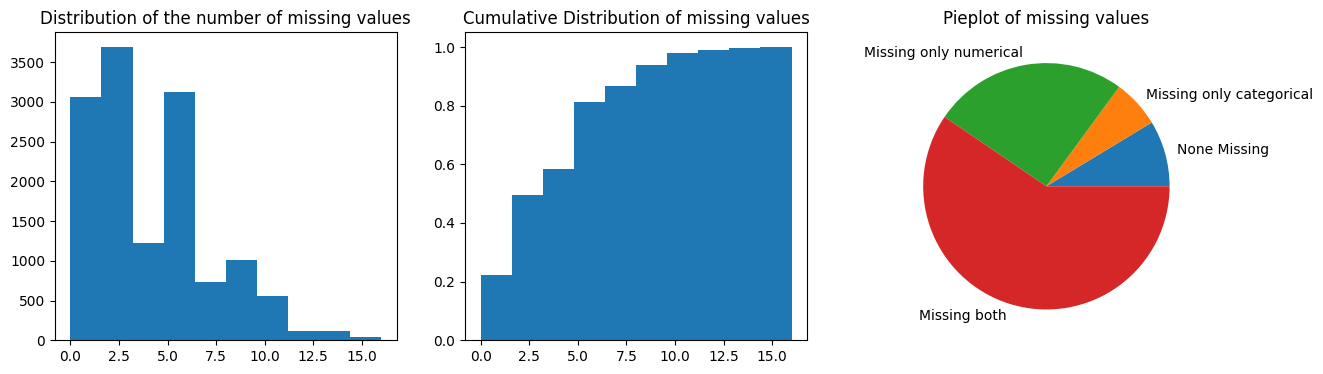

In [7]:
missing_categorical = np.zeros(len(workdf)) #array containing for each row the number of missing categorical attributes 
missing_numerical = np.zeros(len(workdf)) #array containing for each row the number of missing numerical attributes
missing_count = dict()
for col in cat_col_names:  #for each categorical feature
    tmp01 = (workdf[col].str.lower()=='not given/unknown')# array indicating if the value of the column is missing
    workdf.loc[tmp01, col] = np.nan #setting missing values as NaN
    tmp01 = tmp01.astype(int)
    missing_categorical = missing_categorical + tmp01
    missing_count[col] = sum(tmp01)
for col in num_col_names:
    tmp01 = workdf[col].isna().astype(int)
    missing_numerical = missing_numerical + tmp01
    missing_count[col] = sum(tmp01)


#  ------- Histogram and Pieplot -------

missing = missing_categorical + missing_numerical #array containing for each row the number of missing attributes

pie_label = ['None Missing', 'Missing only categorical', 'Missing only numerical', 'Missing both']
missing_categorical_bool = missing_categorical.astype(bool) #True if row contains at least one missing categorical value
missing_numerical_bool = missing_numerical.astype(bool) #True if row contains at least one missing numerical value

none_missing = np.logical_and(np.logical_not(missing_numerical_bool), np.logical_not(missing_categorical_bool)) #True if row contais all numerical and categorical values
missing_only_categorical = np.logical_and(missing_categorical_bool, np.logical_not(missing_numerical_bool)) #True if row misses only categorical data
missing_only_numerical = np.logical_and(missing_numerical_bool, np.logical_not(missing_categorical_bool)) #True if row misses only numerical data
missing_both = np.logical_and(missing_categorical_bool, missing_numerical_bool) #True if row misses both numerical and categorical data

pie_data = [none_missing.sum(), missing_only_categorical.sum(), missing_only_numerical.sum(), missing_both.sum()]

fig, axs= plt.subplots(1,3)
fig.set_size_inches(15,4)
axs[0].hist(missing)
axs[0].set_title('Distribution of the number of missing values')
axs[1].hist(missing, cumulative=True, density = True)
axs[1].set_title('Cumulative Distribution of missing values')
axs[2].pie(pie_data, labels = pie_label)
axs[2].set_title('Pieplot of missing values')

plt.grid(linewidth = 1)
plt.show()


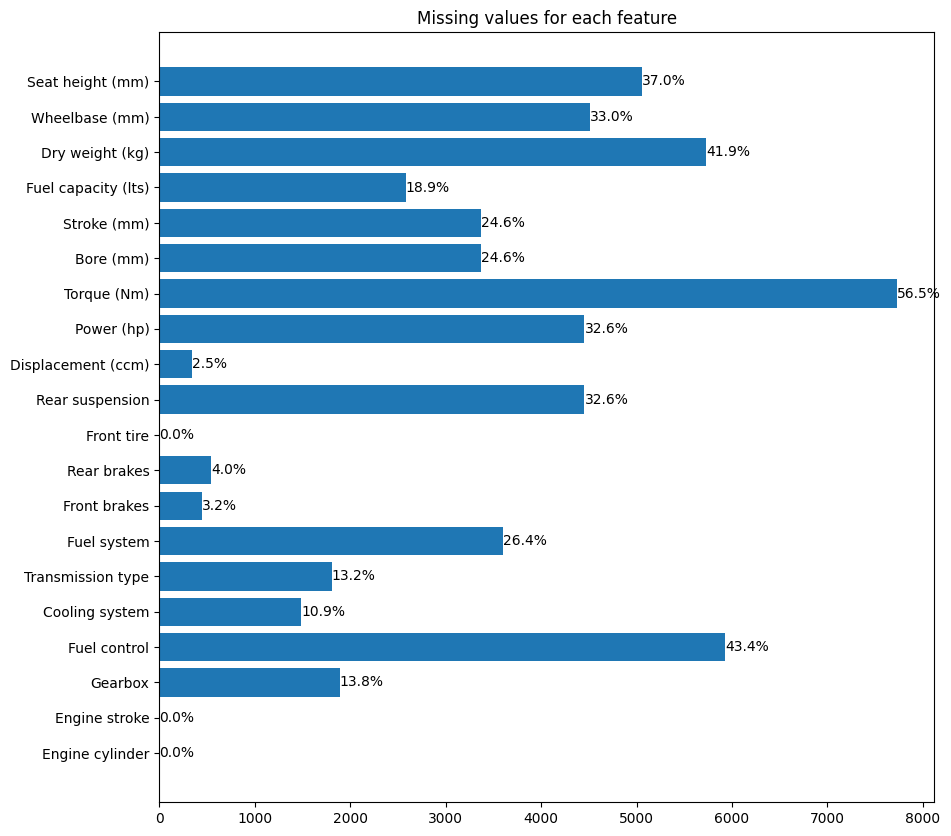

In [8]:
#ornella ha aggiunto: percentuali di missing values per ogni colonna
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.barh(list(missing_count.keys()), missing_count.values())
ax.set_title('Missing values for each feature')

# Add text labels to each bar
for i, (key, value) in enumerate(missing_count.items()):
    perc = value / len(workdf)
    ax.text(value, i, f'{perc:.1%}', ha='left', va='center')

plt.show()

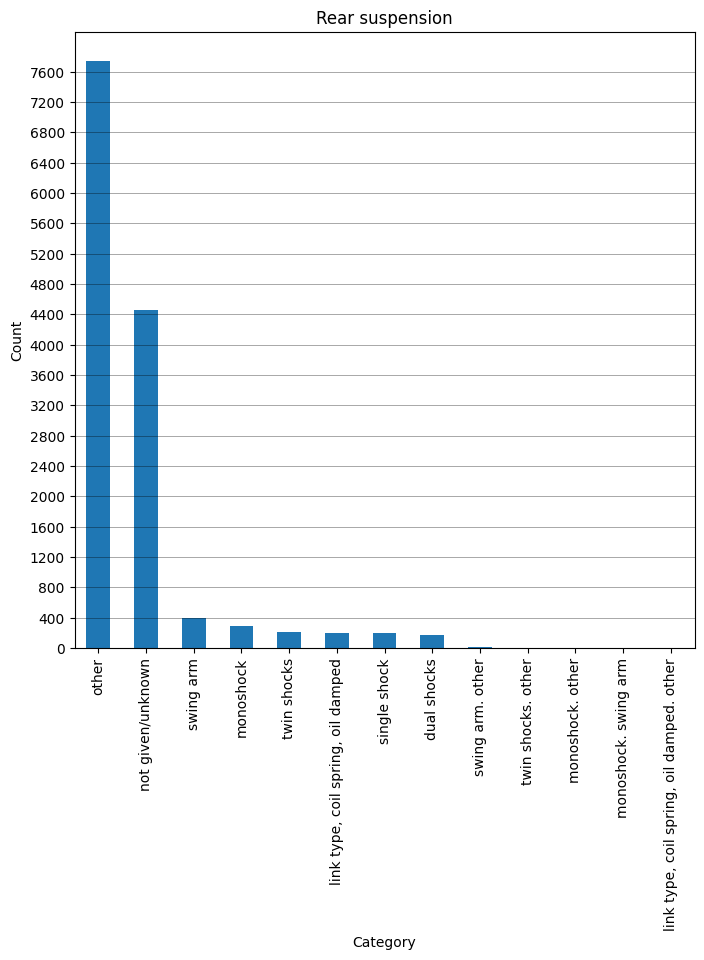

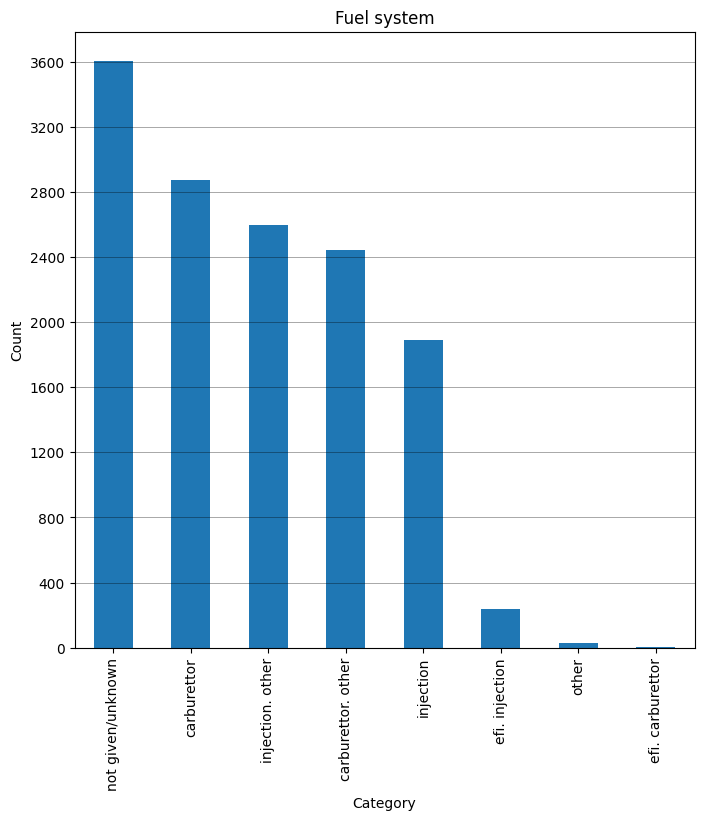

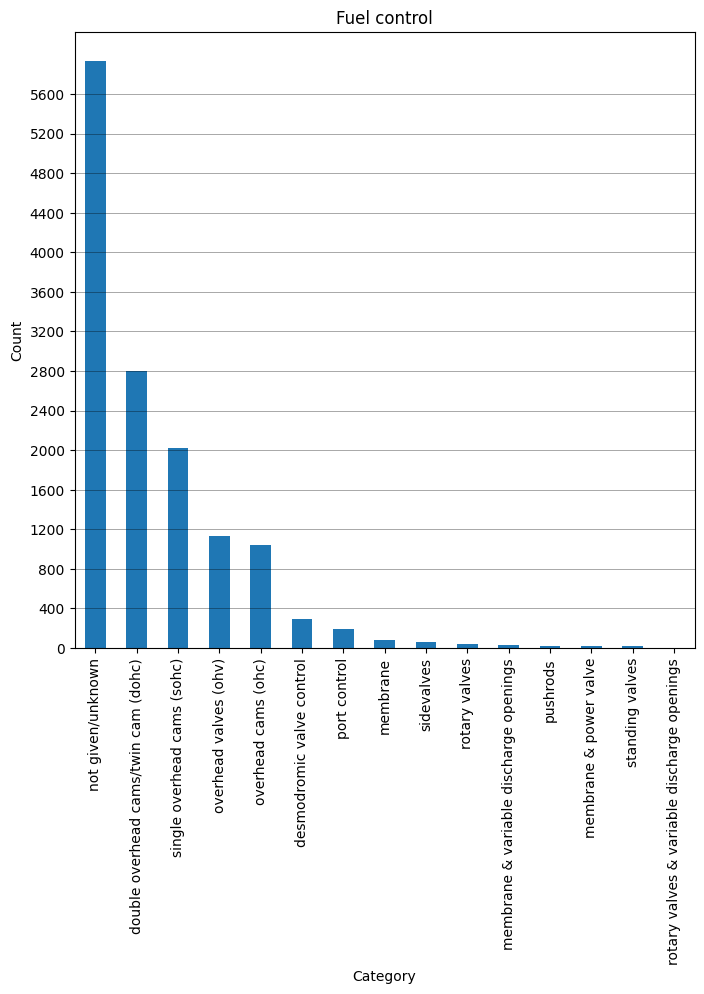

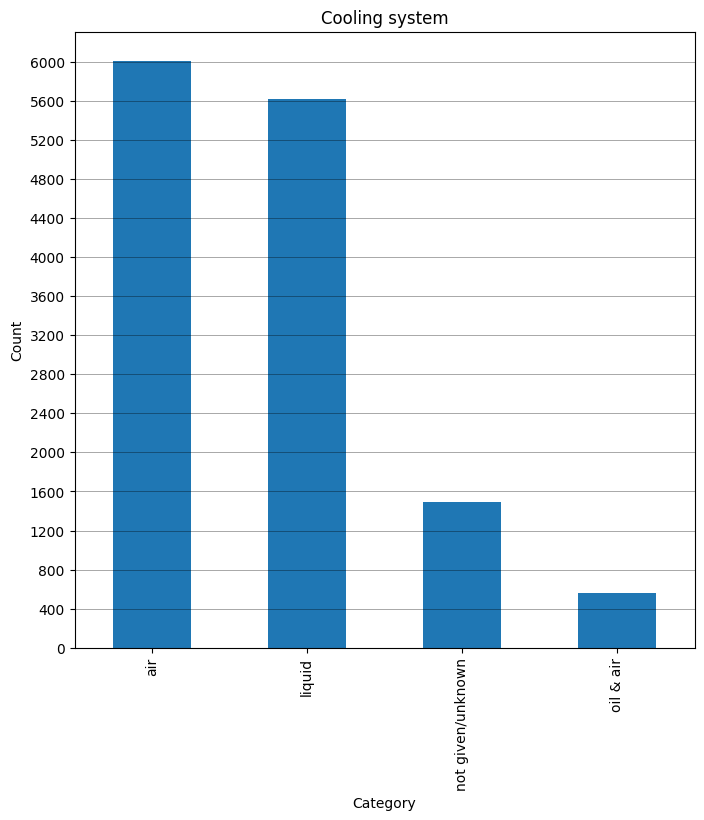

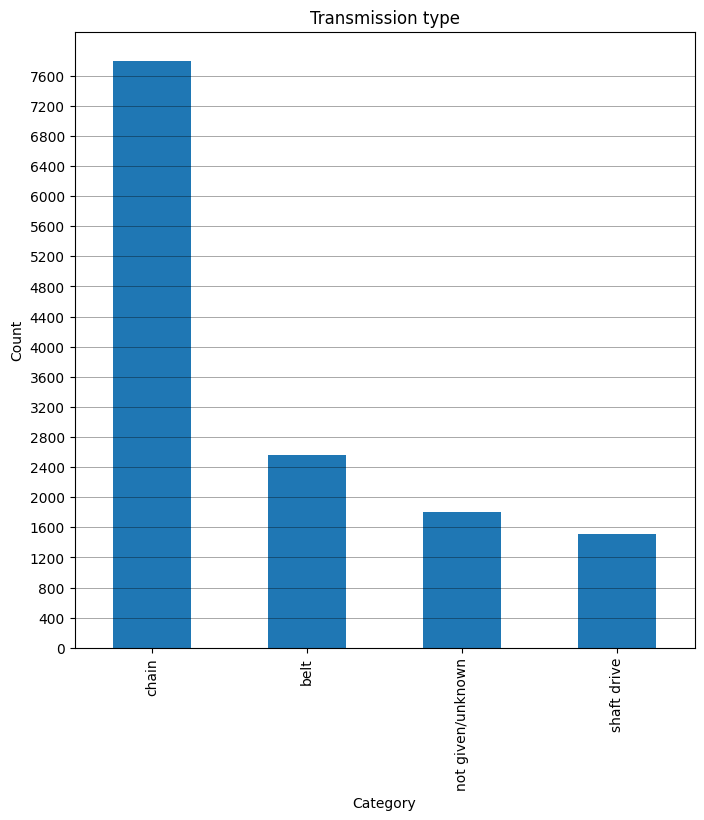

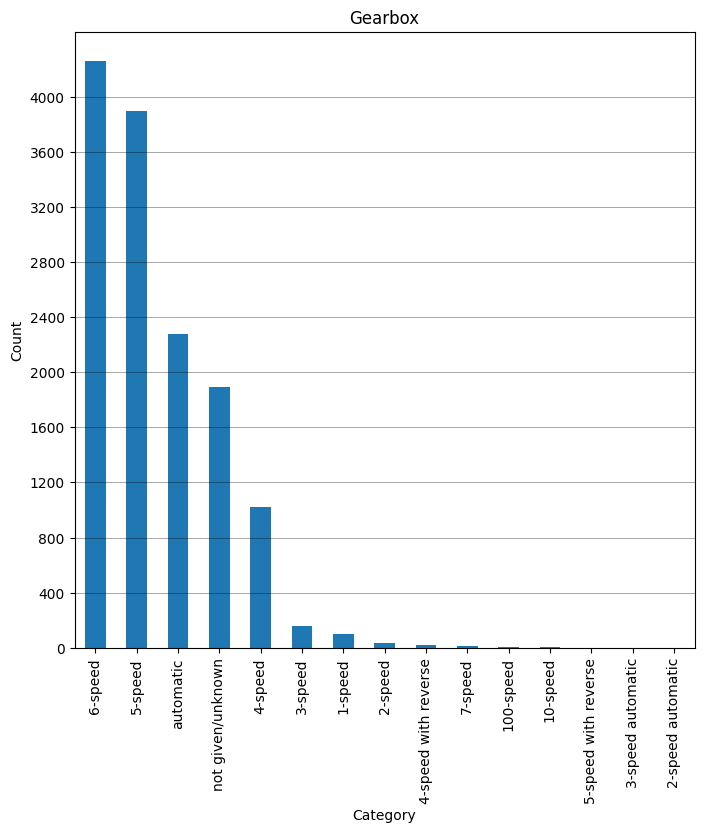

In [9]:
###Here we plot the histogram of values of the categorical values with over 10% of missing values. This will help us decide what to do with values missing.
cat_to_inspect = ['Rear suspension', 'Fuel system', 'Fuel control', 'Cooling system', 'Transmission type', 'Gearbox']


# for col in cat_to_inspect:
#     plt.figure(figsize=(8,8))
#     workdf[col].value_counts(dropna=False).plot(kind='bar', ax=ax)
#     plt.title(col)
#     plt.xlabel('Category')
#     plt.ylabel('Count')
#     plt.grid()
#     plt.show()

for col in cat_to_inspect:
    plt.figure(figsize=(8, 8))
    ax = plt.gca()  # create axis object
    hist = workdf[col].value_counts(dropna=False).plot(kind='bar', ax=ax)
    yticks = np.arange(0, max(workdf[col].value_counts(dropna=False))+10, 400)
    ax.set_title(col)  # set title using axis object
    ax.set_xlabel('Category')  # set x-label using axis object
    ax.set_ylabel('Count')  # set y-label using axis object
    ax.set_yticks(yticks)
    ax.grid(True, axis='y', linewidth=0.4, alpha = 0.6)  # add grid lines

    # modify x-axis tick labels
    tick_labels = ax.get_xticklabels()
    new_tick_labels = [label.get_text().replace('nan', 'not given/unknown') for label in tick_labels]
    ax.set_xticklabels(new_tick_labels)

    plt.show()
#### aggiustare, magari eliminare#########

llidea:
1. togliamo le righe che hanno troppi missing values;
2. facciamo il replacement con la moda;
3. NON facciamo il replacement sulle colonne categoriche con tanti missing values;
4. Torque (Nm) ha praticamente tutti missing values, che sia da togliere direttamente dall'analisi?

In [10]:
#drop entire columns
workdf.drop('Torque (Nm)', axis=1, inplace=True)   #    questo ha davvero troppi missing values, non ha senso tenerlo
workdf.drop('Rear suspension', axis=1, inplace=True)  #questo ha solo dati other /unknown e le altre (poche categorie hanno una descrizione mista "," e "."
workdf.drop('Fuel control', axis=1, inplace=True)    #questo ha lo stesso significato di engine Stroke (categorical) che però non ha missing values

num_col_names.remove('Torque (Nm)')
cat_col_names.remove('Fuel control')
cat_col_names.remove('Rear suspension')
del categorical_columns['Fuel control']
del categorical_columns['Rear suspension']

#Drop entire rows if more than a half of features is missing
missing_threshold = int((workdf.shape[1]-5)/3)  # righe con più del 33% delle features missing
perc = sum(missing[missing>missing_threshold])/sum(missing)*100
workdf = workdf.loc[missing <= missing_threshold, :]

print('Rows with more than', missing_threshold, 'missing values have been deleted.', f'{perc:.2f}%', 'of the data has been deleted')
print("Dataframe updated dimensions: ", workdf.shape)


Rows with more than 5 missing values have been deleted. 63.98% of the data has been deleted
Dataframe updated dimensions:  (8819, 22)


In [11]:
#final step of Handling missing values by replacing with mode (categorical), with mean (numerical), or remark as another category (unknown).

cat_to_replace = ['Engine cylinder', 'Engine stroke', 'Front brakes', 'Rear brakes', 'Front tire','Cooling system']
cat_to_fill = ['Gearbox', 'Transmission type', 'Fuel system']

for col in cat_to_replace:
     mode = min(workdf[col].mode())
     workdf[col]= workdf[col].fillna(value = mode) #replace with the mode

for col in cat_to_fill:
    workdf[col] = workdf[col].fillna('unknown')  #è sbagliato rimpiazzare con other secondo me perchè other è gia parte delle features

for col in num_col_names:
    colmean=workdf[col].mean()
    workdf[col]=workdf[col].fillna(value = colmean) #replace with the mean

workdf.head(7)

Brand            Model  Year    Category  Rating  Displacement (ccm)   
37  adiva         ad 125le  2010     Scooter     1.9               124.0  \
45  adiva          ad3 300  2019     Scooter     NaN               299.0   
48  adiva          ad3 400  2019     Scooter     NaN               399.0   
58  adiva             n125  2010     Scooter     NaN               124.0   
73  adler            m 200  1953  Naked bike     NaN               200.0   
79  adler          m 250 s  1953    Allround     NaN               247.0   
88  adler  mbs 250 favorit  1959    Allround     NaN               250.0   

    Power (hp)  Engine cylinder Engine stroke    Gearbox  Bore (mm)   
37        13.0  single cylinder   four-stroke  automatic       48.8  \
45        29.4  single cylinder   four-stroke  automatic       72.7   
48        36.7  single cylinder   four-stroke  automatic       84.0   
58        10.3  single cylinder   four-stroke    unknown       52.4   
73        11.0             twin    two-stroke    4-speed       48.0   
79        16.0             twin    two-stroke    4-speed       54.0   
88        16.0             twin    two-stroke    4-speed       54.0   

    Stroke (mm)  Fuel capacity (lts) Cooling system Transmission type   
37         57.0            13.500000         liquid              belt  \
45         72.0            11.000000         liquid           unknown   
48         72.0            11.000000         liquid           unknown   
58         57.8             6.000000         liquid           unknown   
73         54.0            12.922086            air             chain   
79         54.0            12.922086            air             chain   
88         54.0            15.000000            air             chain   

    Dry weight (kg)  Wheelbase (mm)  Seat height (mm)  Fuel system   
37            171.0     1640.000000        794.826584  carburettor  \
45            202.0     1560.000000        700.000000    injection   
48            257.0     1560.000000        770.000000    injection   
58            108.0     1320.000000        800.000000  carburettor   
73            130.0     1426.806359        794.826584  carburettor   
79            135.0     1426.806359        794.826584  carburettor   
88            165.0     1426.806359        794.826584  carburettor   

                    Front brakes                   Rear brakes Front tire  
37                   single disc                   single disc      other  
45                   single disc                   single disc      other  
48                   single disc                   single disc      other  
58                   single disc  expanding brake (drum brake)  120/70-12  
73  expanding brake (drum brake)  expanding brake (drum brake)      other  
79  expanding brake (drum brake)  expanding brake (drum brake)      other  
88  expanding brake (drum brake)  expanding brake (drum brake)      other

## Ex.2 Encoding of categorical data

Visualizziamo le features categoriche e di conseguenza prendiamo decisioni


In [12]:
#dictionary updating after missing values handle
for col in cat_col_names:
    categorical_columns[col] = workdf[col].unique() #append its unique values into a dict entry

for col, unique_values in categorical_columns.items():
    print(f"Column '{col}' has {len(unique_values)} unique categorical values:")
    for i, val in enumerate(unique_values):
        print(f"   {i+1}. {val}")

Column 'Engine cylinder' has 14 unique categorical values:
   1. single cylinder
   2. twin
   3. v2
   4. four cylinder boxer
   5. v4
   6. diesel
   7. square four cylinder
   8. v8
   9. in-line four
   10. in-line three
   11. in-line six
   12. two cylinder boxer
   13. v6
   14. six cylinder boxer
Column 'Engine stroke' has 4 unique categorical values:
   1.  four-stroke
   2.  two-stroke
   3. diesel
   4. square four cylinder
Column 'Gearbox' has 11 unique categorical values:
   1. automatic
   2. unknown
   3. 4-speed
   4. 1-speed
   5. 5-speed
   6. 3-speed
   7. 6-speed
   8. 2-speed
   9. 10-speed
   10. 7-speed
   11. 100-speed
Column 'Cooling system' has 3 unique categorical values:
   1. liquid
   2. air
   3. oil & air
Column 'Transmission type' has 4 unique categorical values:
   1. belt
   2. unknown
   3. chain
   4. shaft drive
Column 'Fuel system' has 8 unique categorical values:
   1. carburettor
   2. injection
   3. carburettor. other
   4. efi. injection
   5

Now we'll assign one color to each categorical or numerical feature, before performing one-hot or special encoding. This will help us to visulize PCA results and to represent the special encoded columns with a reference to their original category.

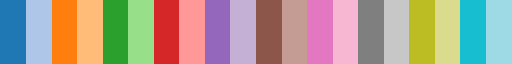

In [13]:
#DEFINE COLORS FOR EACH FEATURE BEFORE CATEGORICAL ENCODING
num_features = workdf.shape[1] - 5 #subtracting the label columns

#define colormap and get the colors
colors = cm.tab20.colors
feature_colors = colors[:num_features]

#create a dictionary: Feature -> color
general_feature_colors = {}
for i in range(num_features):
    general_feature_colors[workdf.iloc[:, 5:].columns[i]] = feature_colors[i]


######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.tab20)
#############################################################

Notiamo che le colonne "Fuel system", "Front brakes" e "Rear brakes" che utilizzano il particolare encoding $\alpha . \beta \dots$

Usiamo il one-hot encoding perché le feature categoriche non hanno un ordinamento intrinseco quindi non possiamo enumerare le caratteristiche (evitiamo di generare un ordinamento fittizio delle features)

In [14]:
workdf_encoded = workdf.iloc[:, :5]
special_enc_col = ['Front brakes', 'Rear brakes', 'Fuel system']
#Categorical features
for col in cat_col_names:  #for each feature column
    if col in special_enc_col:
        workdf[col]=[entry.split(sep='. ') for entry in workdf[col]]#split every entry into list of categories
        mlb = MultiLabelBinarizer(sparse_output=True)#initialize a multilabel binarizer
        mlb_df = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(workdf[col]), #perform the multilabel encoding
                                                   index = workdf_encoded.index,
                                                   columns=[col + '_' + c for c in mlb.classes_])#generate a dataframe from the encoding
        general_feature = col.split('_')[0]
        new_cols = [col + '_' + c for c in mlb.classes_]
        color = general_feature_colors[general_feature]
        for new_col in new_cols:
            general_feature_colors[new_col] = color


        workdf_encoded=workdf_encoded.join(mlb_df)#join the encoded df with the encoding dataframe
    else:                  #classical one-hot encoding
        workdf_encoded = workdf_encoded.join(pd.get_dummies(workdf[col], prefix=col))#join the result of pd.get_dummies with the encoding df

#Numerical features
for col in num_col_names:
    workdf_encoded = workdf_encoded.join(workdf[col])       # join it in the encoded DF because no encoding is needed


In [15]:
Xworkdf = workdf_encoded.iloc[:, 5:]
LabelsDF = workdf_encoded.iloc[:, :5]

display(LabelsDF)

print("Updated dataframe dimensions: ", Xworkdf.shape, "\nThe resulting features are: \n", Xworkdf.columns)

Brand                Model  Year    Category  Rating
37       adiva             ad 125le  2010     Scooter     1.9
45       adiva              ad3 300  2019     Scooter     NaN
48       adiva              ad3 400  2019     Scooter     NaN
58       adiva                 n125  2010     Scooter     NaN
73       adler                m 200  1953  Naked bike     NaN
...        ...                  ...   ...         ...     ...
38428  zündapp               ks 601  1950    Allround     NaN
38431  zündapp               ks 601  1953    Allround     3.9
38445  zündapp  ks 750 kardan sport  1941    Allround     NaN
38449  zündapp  ks 750 kardan sport  1947    Allround     NaN
38468  zündapp                z 249  1923       Sport     NaN

[8819 rows x 5 columns]

Updated dataframe dimensions:  (8819, 81) 
The resulting features are: 
 Index(['Engine cylinder_diesel', 'Engine cylinder_four cylinder boxer',
       'Engine cylinder_in-line four', 'Engine cylinder_in-line six',
       'Engine cylinder_in-line three', 'Engine cylinder_single cylinder',
       'Engine cylinder_six cylinder boxer',
       'Engine cylinder_square four cylinder', 'Engine cylinder_twin',
       'Engine cylinder_two cylinder boxer', 'Engine cylinder_v2',
       'Engine cylinder_v4', 'Engine cylinder_v6', 'Engine cylinder_v8',
       'Engine stroke_ four-stroke', 'Engine stroke_ two-stroke',
       'Engine stroke_diesel', 'Engine stroke_square four cylinder',
       'Gearbox_1-speed', 'Gearbox_10-speed', 'Gearbox_100-speed',
       'Gearbox_2-speed', 'Gearbox_3-speed', 'Gearbox_4-speed',
       'Gearbox_5-speed', 'Gearbox_6-speed', 'Gearbox_7-speed',
       'Gearbox_automatic', 'Gearbox_unknown', 'Cooling system_air',
       'Cooling system_liquid', 'Cooling system_oil & a

## Ex.3 Preprocessing and PCA

Creating two datasets from Xworkdf: Xworkdf_mm scaled using MinMaxScaler(), Xworkdf_std scaled with StandardScaler()

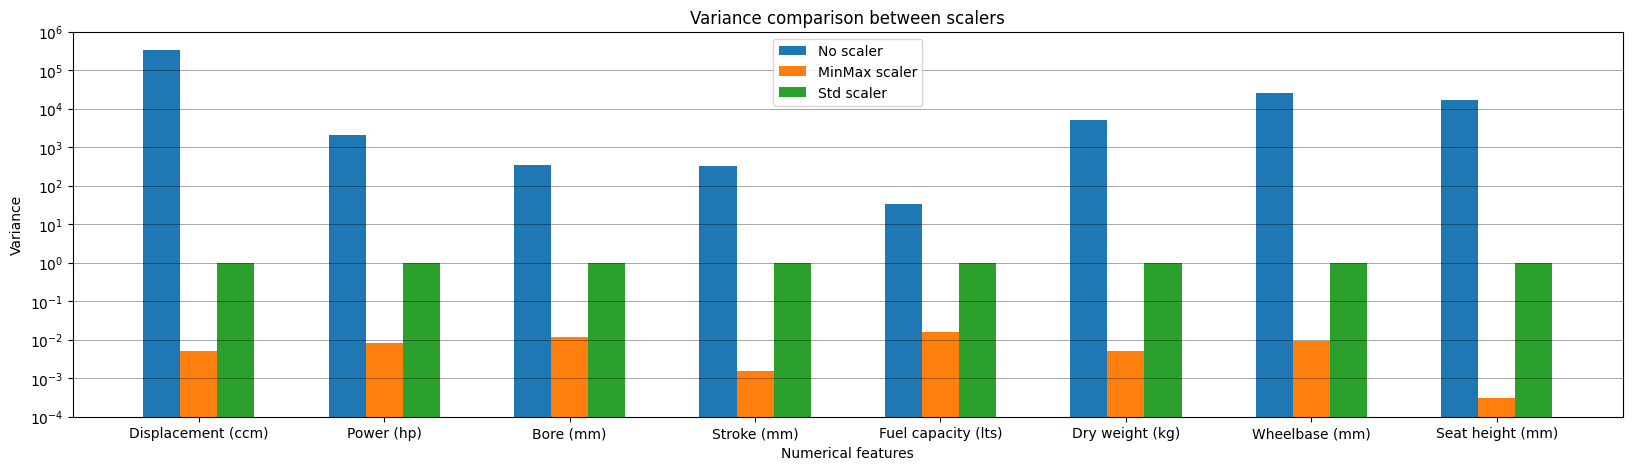

In [16]:
data_mat = Xworkdf.to_numpy()

scaler_mm = MinMaxScaler()
Xworkdf_mm = pd.DataFrame(scaler_mm.fit_transform(data_mat), index=Xworkdf.index, columns=Xworkdf.columns)

scaler_std = StandardScaler()
Xworkdf_std = pd.DataFrame(scaler_std.fit_transform(data_mat), index=Xworkdf.index, columns=Xworkdf.columns)

# variance comparison of numerical features
var_numerical = np.array(Xworkdf[num_col_names].var())
var_numerical_mm = np.array(Xworkdf_mm[num_col_names].var())
var_numerical_std = np.array(Xworkdf_std[num_col_names].var())

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
#ax.grid(True, axis='y', linestyle='--')
labels = [l for l in num_col_names]
X_axis = np.arange(len(num_col_names))
bar1 = ax.bar(X_axis-0.2, var_numerical, 0.2, label = 'No scaler')
bar2 = ax.bar(X_axis, var_numerical_mm, 0.2, label = 'MinMax scaler')
bar3 = ax.bar(X_axis+0.2, var_numerical_std, 0.2, label = 'Std scaler')

ax.set_ylabel('Variance')
ax.set_yscale('log')
ax.set_title('Variance comparison between scalers')
ax.set_xlabel('Numerical features')
ax.set_xticks(X_axis)
ax.set_yticks(ticks= np.logspace(-4, 6, 11))
ax.set_xticklabels(labels)
ax.grid(axis='y', linewidth=0.6, alpha = 0.4)
ax.legend()
plt.show()



##### TODO commentare 

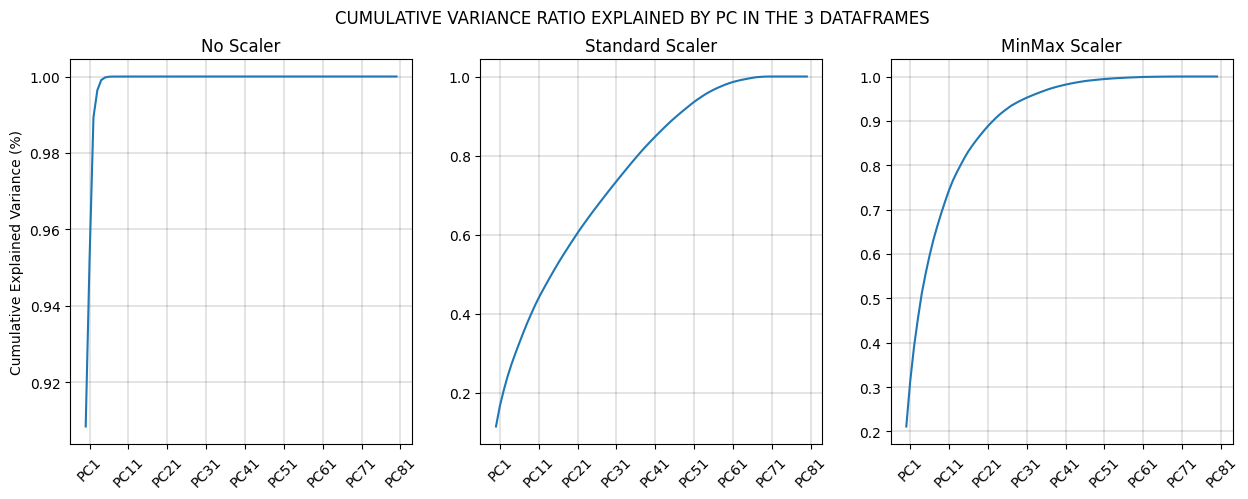

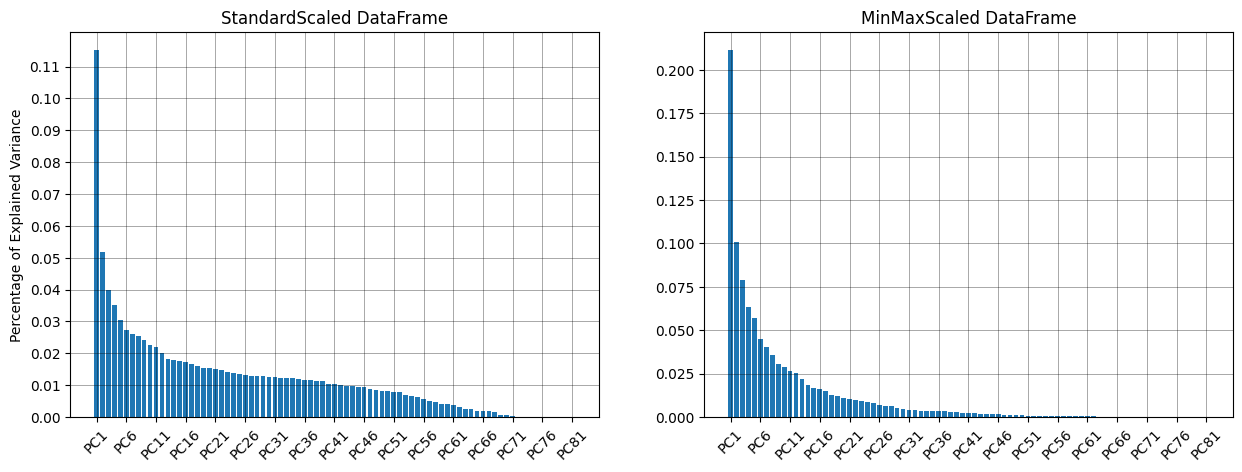

In [17]:
pca_full_noscale = PCA()
pca_full_mm = PCA()
pca_full_std = PCA()

pca_full_noscale.fit(np.array(Xworkdf))
pca_full_std.fit(np.array(Xworkdf_std))
pca_full_mm.fit(np.array(Xworkdf_mm))


expl_var_noscale = pca_full_noscale.explained_variance_ratio_
expl_var_mm = pca_full_mm.explained_variance_ratio_
expl_var_std = pca_full_std.explained_variance_ratio_


#PLOT THE VARIANCE EXPLAINED BY PCA PERFORMED ON EACH DATAFRAME
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,5)
fig.suptitle('CUMULATIVE VARIANCE RATIO EXPLAINED BY PC IN THE 3 DATAFRAMES')
axs[0].plot(expl_var_noscale.cumsum())
axs[0].set_title('No Scaler')
axs[0].set_ylabel('Cumulative Explained Variance (%)')
axs[0].set_xticks(ticks = np.arange(1, pca_full_noscale.n_features_in_+1, 10), labels=[f'PC{i}' for i in range(1, pca_full_noscale.n_features_in_+1, 10)],
           rotation=45)
axs[0].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
axs[1].plot(expl_var_std.cumsum())
axs[1].set_title('Standard Scaler')
axs[1].set_xticks(ticks = np.arange(1, pca_full_std.n_features_in_+1, 10), labels=[f'PC{i}' for i in range(1, pca_full_std.n_features_in_+1, 10)],
           rotation=45)
axs[1].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
axs[2].plot(expl_var_mm.cumsum())
axs[2].set_title('MinMax Scaler')
axs[2].set_xticks(ticks = np.arange(1, pca_full_mm.n_features_in_+1, 10), labels=[f'PC{i}' for i in range(1, pca_full_mm.n_features_in_+1, 10)],
           rotation=45)
axs[2].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)

plt.show()

#show barplot representing the variance explained by each principal component
#Standard Scaler
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,5)
axs[0].set_title('StandardScaled DataFrame')
axs[0].set_ylabel('Percentage of Explained Variance')
axs[0].bar(range(1, len(expl_var_std) + 1), expl_var_std, align='center')

axs[0].set_xticks(ticks = np.arange(1, pca_full_std.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_std.n_features_in_+1, 5)], rotation=45)
axs[0].set_yticks(np.arange(0, expl_var_std[0], 0.01))

axs[0].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
#Min-Max Scaler
axs[1].bar(range(1, len(expl_var_mm) + 1), expl_var_mm, align='center')
axs[1].set_xticks(ticks = np.arange(1, pca_full_mm.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_mm.n_features_in_+1, 5)], rotation=45)
axs[1].set_title('MinMaxScaled DataFrame')
axs[1].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
plt.show()

## Ex. 4. Dimensionality Reduction and Interpretation of the PCs
Let's now find the number of principal components explaining at least the 35% of the total variance. Then we'll select m features according to  m = min{m_35%
, 5}.

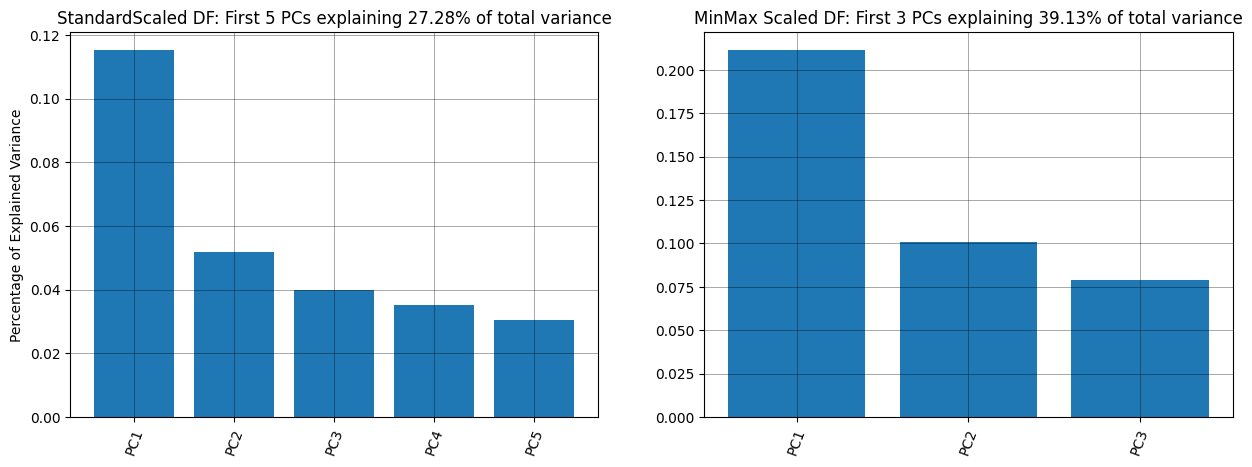

In [18]:
#choosing m
m_prime_std = np.argmax(np.cumsum(expl_var_std) >= 0.35) + 1
m_prime_mm = np.argmax(np.cumsum(expl_var_mm) >= 0.35) + 1

m_std = min(m_prime_std, 5)
m_mm = min(m_prime_mm, 5)

#perform PCA using the first m choosen principal component only
# INITIALIZE THE PCA
pca_m_std = PCA(n_components=m_std)
pca_m_mm = PCA(n_components=m_mm)

# FIT THE PCA
results_std = pca_m_std.fit_transform(Xworkdf_std)
results_mm = pca_m_mm.fit_transform(Xworkdf_mm)
#barplots of the variance explained

expl_var_std = pca_m_std.explained_variance_ratio_
expl_var_mm = pca_m_mm.explained_variance_ratio_

#STANDARD SCALER
round_expl_var_ratio = np.round(expl_var_std.sum() * 100, 2)
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,5)
axs[0].bar(range(1, m_std + 1), expl_var_std[:m_std], align='center')
axs[0].set_title(f"StandardScaled DF: First {format(m_std)} PCs explaining {round_expl_var_ratio}% of total variance")
axs[0].set_xticks(ticks= range(1, m_std + 1), labels = [f'PC{i}' for i in range(1, m_std+1)], rotation=70)
axs[0].set_ylabel('Percentage of Explained Variance')
axs[0].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)

#MINMAX SCALER
round_expl_var_ratio = np.round(expl_var_mm.sum() * 100, 2)
axs[1].bar(range(1, m_mm + 1), expl_var_mm[:m_mm], align='center')
axs[1].set_title(f"MinMax Scaled DF: First {format(m_mm)} PCs explaining {round_expl_var_ratio}% of total variance")
axs[1].set_xticks(ticks= range(1, m_mm + 1), labels = [f'PC{i}' for i in range(1, m_mm+1)], rotation=70)
axs[1].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)

plt.show()

#### StandardScaler Results.
Loading graph for the 5 principal component to interpret results. For each PC, we will print a barplot showing the contribute o each feature of the top 20 selected. Moreover, for each PC, the feature with greatest contribute w.r.t. to the threshold $\epsilon = \sqrt{1/n}$ ($n$ is the number of features) will be selected to interpret the meaning of the PCs.

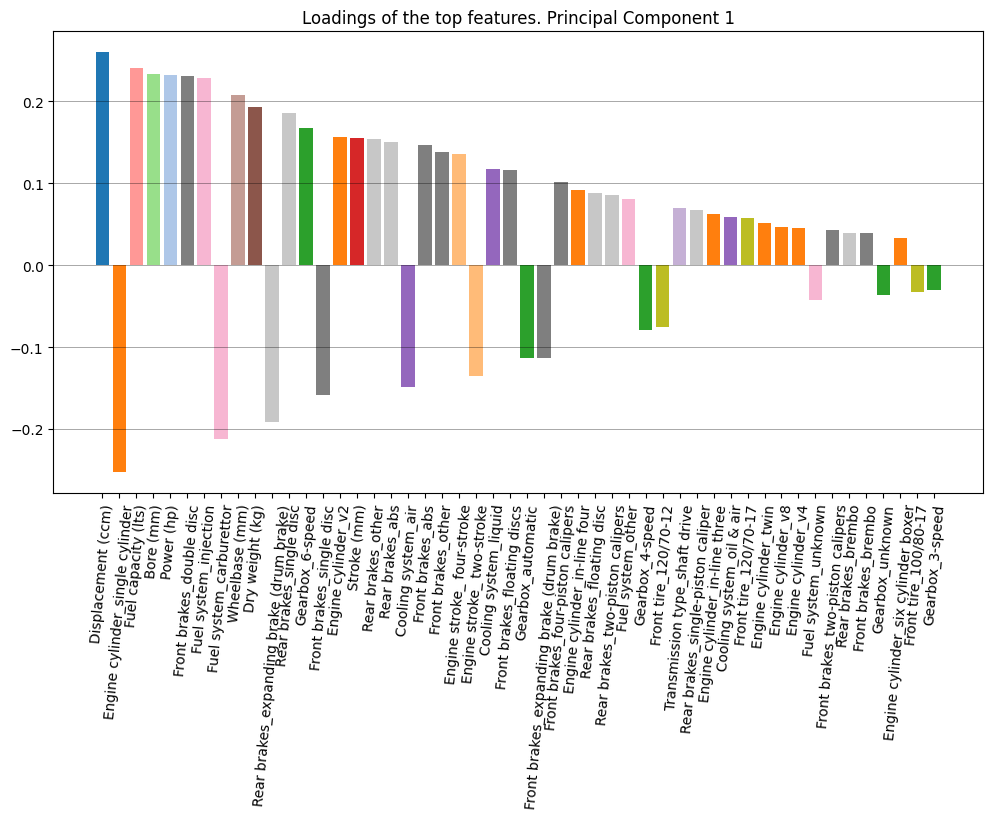

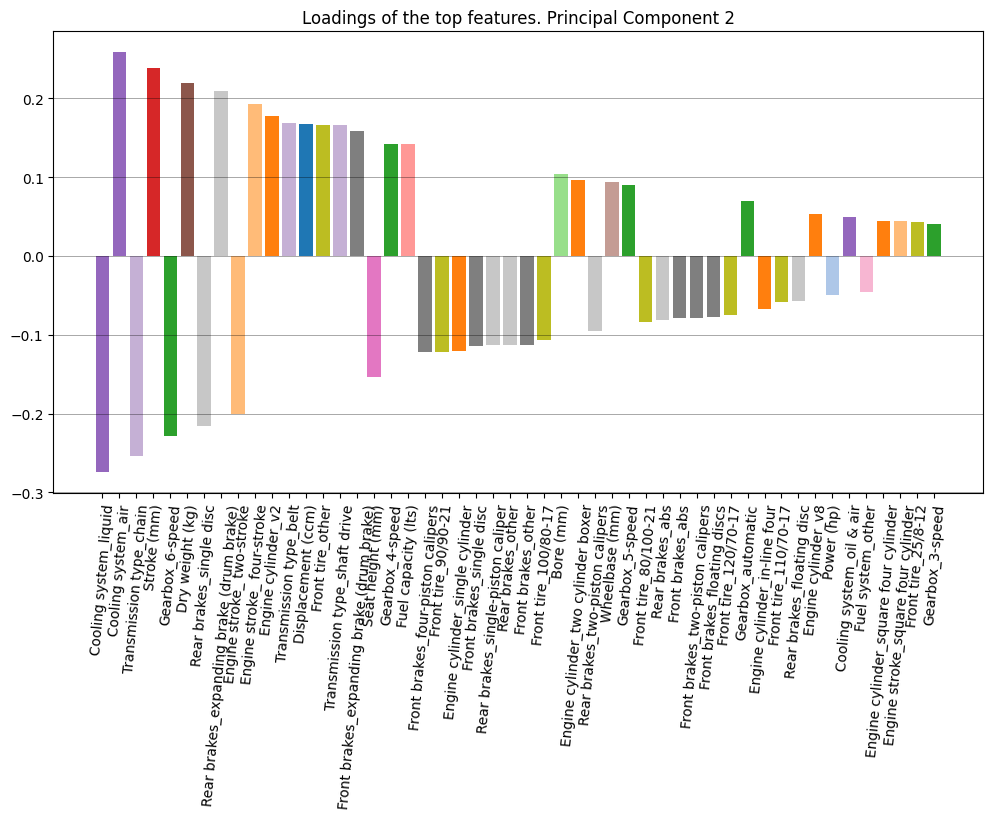

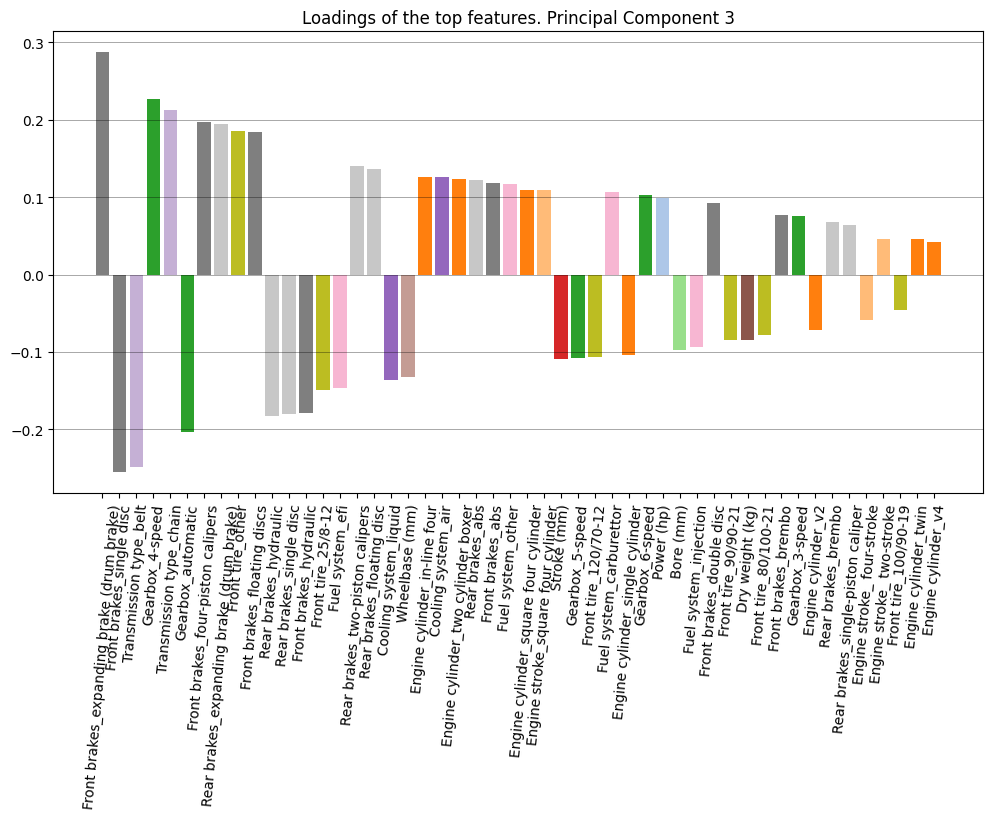

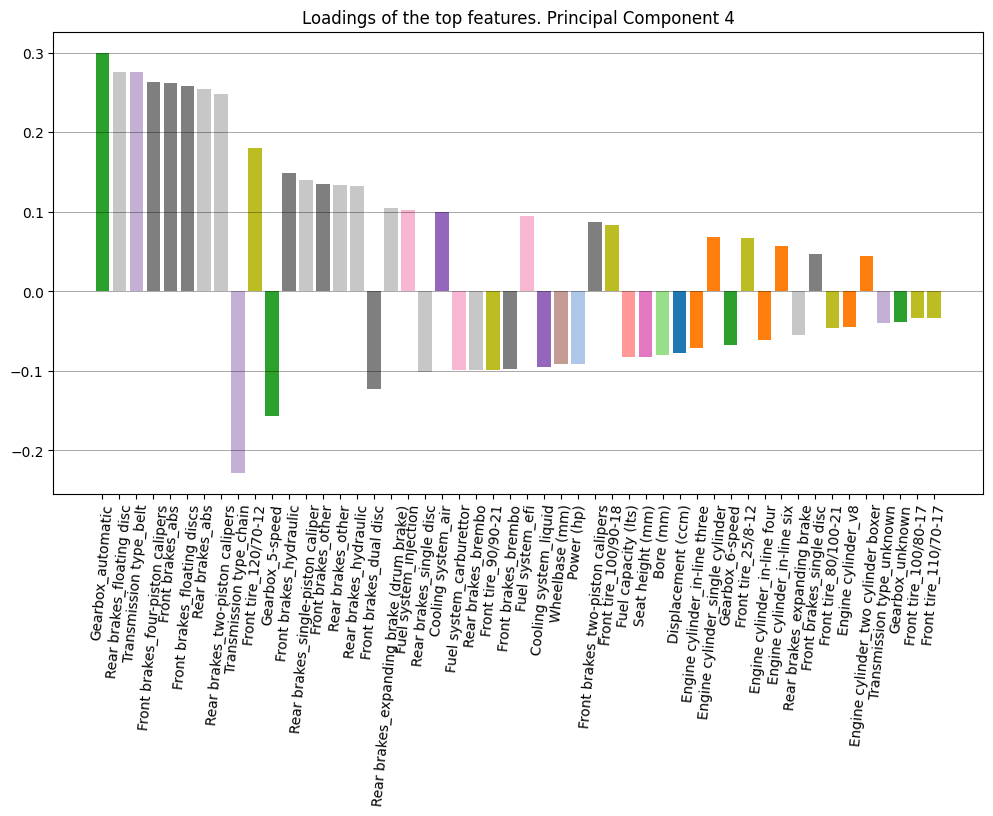

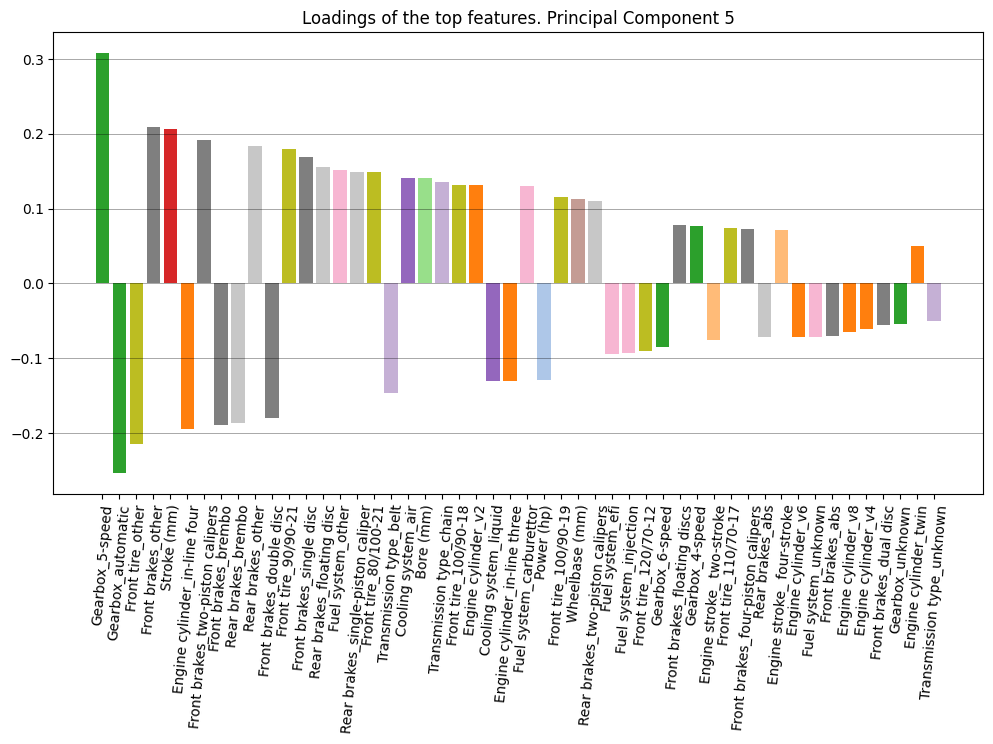

Results on StandardScaled DF for the first 5 PCs
Top 4 features for PC1: ['Displacement (ccm)', 'Engine cylinder_single cylinder', 'Fuel capacity (lts)', 'Bore (mm)']
Top 4 features for PC2: ['Cooling system_liquid', 'Cooling system_air', 'Transmission type_chain', 'Stroke (mm)']
Top 4 features for PC3: ['Front brakes_expanding brake (drum brake)', 'Front brakes_single disc', 'Transmission type_belt', 'Gearbox_4-speed']
Top 4 features for PC4: ['Gearbox_automatic', 'Rear brakes_floating disc', 'Transmission type_belt', 'Front brakes_four-piston calipers']
Top 4 features for PC5: ['Gearbox_5-speed', 'Gearbox_automatic', 'Front tire_other', 'Front brakes_other']


In [19]:
#here I'll print some tries to show which features are the best performing in my model
n_topfeatures = 50
#StandardScaler model PCA
#get the loadings of each feature for each pc of the m selected
loadings = pca_m_std.components_#* np.sqrt(expl_var_std[:m_std])
topfeat_std = [] #this is an array of list: i stands for the i-th PC, and the cell is a ordered list of the 5 best influencing feature for that PC
for i in range(m_std):
    # Sort the loadings for the current component in descending order
    component_loadings = loadings[i]
    sorted_loadings = sorted(enumerate(component_loadings), key=lambda x: -abs(x[1]))
    #extract the n top features and save them in a list
    top_feature_indices = [index for index, _ in sorted_loadings[:n_topfeatures]]
    top_features_for_component = list(Xworkdf_std.columns[top_feature_indices])
    topfeat_std.append(top_features_for_component)
    #plot the barplot
    fig, ax = plt.subplots(figsize=(12,6))
    #using the general feature color to set the color of each bar
    feature_colors = [general_feature_colors[c.split('_')[0]] for c in top_features_for_component]
    ax.bar(top_features_for_component, component_loadings[top_feature_indices], color=feature_colors)
    ax.set_title(f'Loadings of the top features. Principal Component {i+1}')
    ax.tick_params(axis='x', rotation=85)
    ax.grid(axis='y', linewidth=0.4, alpha = 0.6)
    plt.show()


#print the top features for each component
print(f"Results on StandardScaled DF for the first {m_std} PCs")
for i in range(m_std):
    print(f"Top 4 features for PC{i+1}: {topfeat_std[i][:4]}")

## Interpreting results:
PC1: **power and performance** being displacement, double disc of positive loading while single cylinder of negative loading, indicator of a less powerful technology
PC2: **Fuel and cooling system variations**. (vedi chatgpt) A principal component with a high loading for this feature might indicate that there is variability in the available information about the motorcycles in the dataset.
PC3: It seems like this principal component captures a contrast between motorcycles with modern automatic transmissions and belt drive systems, versus those with chain drive systems and an unknown fuel system. Potentially call this component something like **Modern Drive Systems** or **Drivetrain Technology**. The negative loading for "Fuel system_unknown" suggests that this component may be more strongly related to the type of drivetrain technology than the fuel system.
PC4: **Braking System Sophistication**
PC5: **Electric Power** or **Electric Propulsion**.





In [20]:
#GIVING NAMES TO THE PCA COMPONENTS ACCORDING TO LOADINGS

pc_std_names =['Power and performance',
                'Air [+] VS Liquid [-] Cooling system',
                'Drivetrain Technology',
                'Braking System Sophistication',
                'Electric[+] VS Combustion [-] systems']


 ## MinMax scaler results

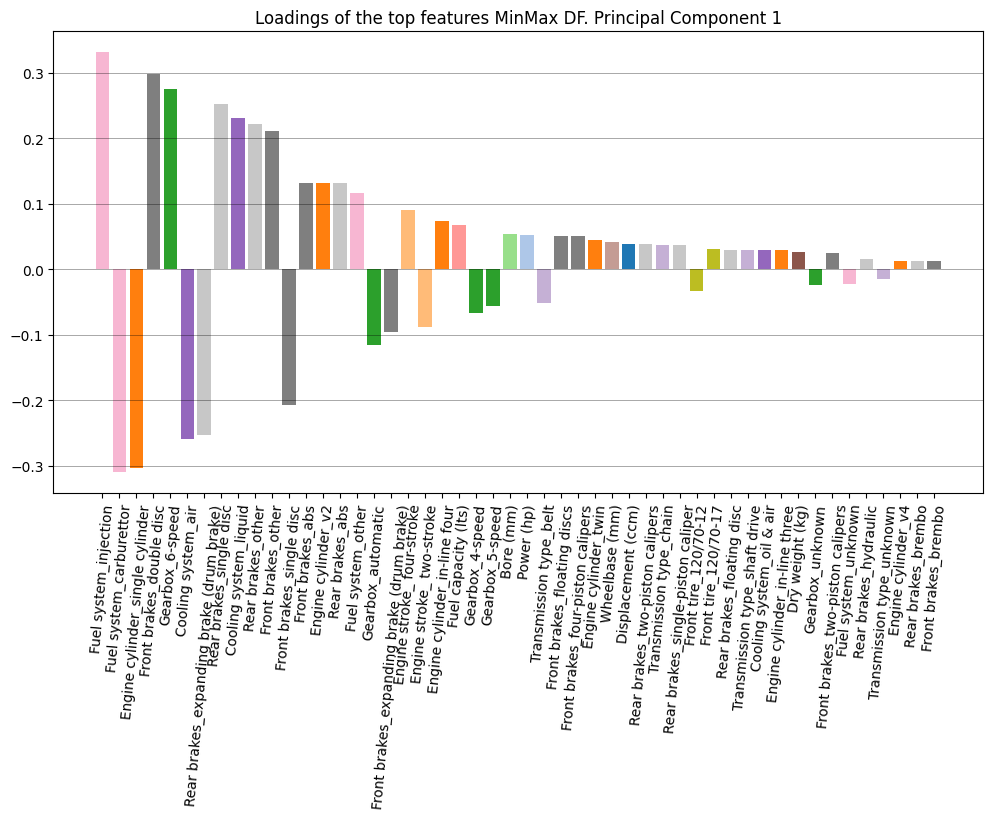

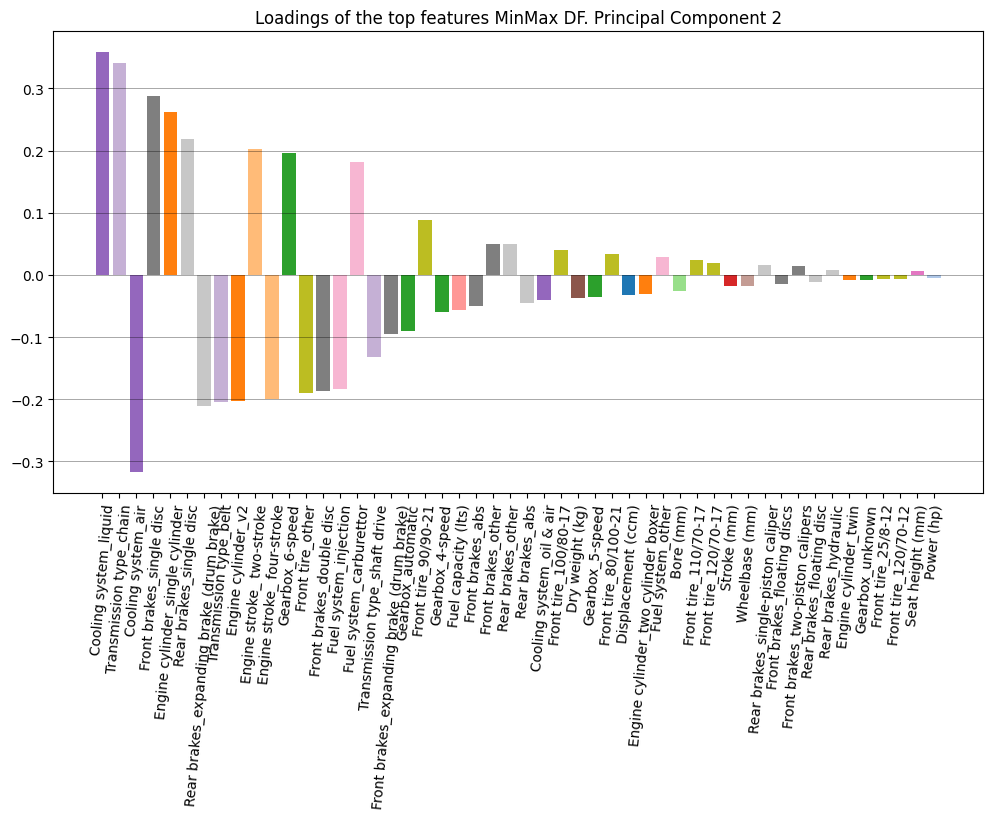

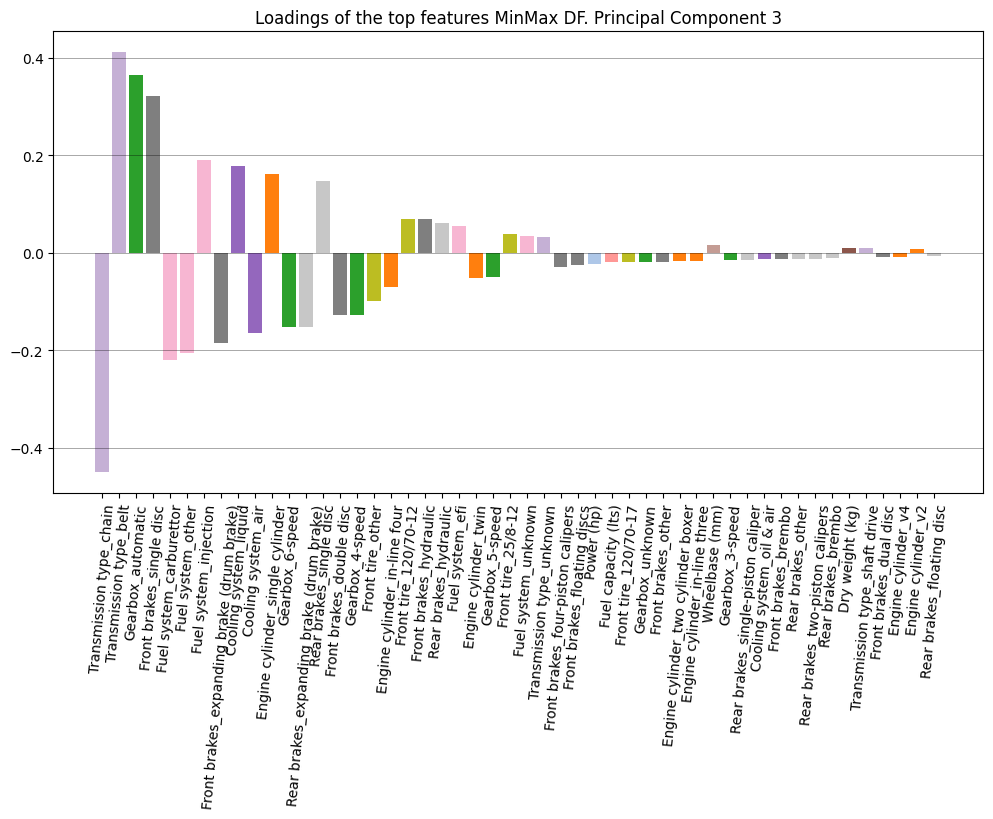


Results on MinMaxScaled DF for the first 3 PCs
Top 5 features for PC1: ['Fuel system_injection', 'Fuel system_carburettor', 'Engine cylinder_single cylinder', 'Front brakes_double disc', 'Gearbox_6-speed']
Top 5 features for PC2: ['Cooling system_liquid', 'Transmission type_chain', 'Cooling system_air', 'Front brakes_single disc', 'Engine cylinder_single cylinder']
Top 5 features for PC3: ['Transmission type_chain', 'Transmission type_belt', 'Gearbox_automatic', 'Front brakes_single disc', 'Fuel system_carburettor']


In [21]:
#MinMax Scaler model PCA
#get the loadings of each feature for each pc of the choosen m
loadings = pca_m_mm.components_
                                        #.T * np.sqrt(expl_var_std[:m_mm])
topfeat_mm = []
for i in range(m_mm):
    # Sort the loadings for the current component in descending order
    component_loadings = loadings[i]
    #sorting loadings of each feature for the i-th pc according to the function: -absolute value of the loading (- is for guaranteeing descending order)
    sorted_loadings = sorted(enumerate(component_loadings), key=lambda x: -abs(x[1]))
    #extract the n top features and save them in a list
    top_feature_indices = [index for index, _ in sorted_loadings[:n_topfeatures]]
    #questo crea una lista con le top features per la comp. princ. i=1,2,3 (PC1, PC2, PC3 una per loop) con i nomi delle colonne dal dataset a seconda degli indici
    top_features_for_component = list(Xworkdf_mm.columns[top_feature_indices])
    topfeat_mm.append(top_features_for_component)

    #plot the barplot
    fig, ax = plt.subplots(figsize=(12,6))
    #using the general feature color to set the color of each bar
    feature_colors = [general_feature_colors[c.split('_')[0]] for c in top_features_for_component]
    ax.bar(top_features_for_component, component_loadings[top_feature_indices], color=feature_colors)
    ax.set_title(f'Loadings of the top features MinMax DF. Principal Component {i+1}')
    ax.tick_params(axis='x', rotation=85)
    ax.grid(axis='y', linewidth=0.4, alpha =0.6)
    plt.show()

print(f"\nResults on MinMaxScaled DF for the first {m_mm} PCs")
#print the top features for each component
for i in range(m_mm):
    print(f"Top 5 features for PC{i+1}: {topfeat_mm[i][:5]}")

## Interpreting results:
PC1: **performance** being the first two and the fourth feature positively associated to the PC1, while cooling system_air is negatively associated, this PC can represent the motorcycle performance or power where air cooling is an indicator of worse performance.
PC2: simpler, basic model (**traditional style** motorcycle)
PC3: belt-driven automatic transmission system, we can say **automatic motorcycle**

In [22]:
#GIVING NAMES TO THE PCA COMPONENTS ACCORDING TO LOADINGS

pc_mm_names =['Performance and power',
              'Cost-effectiveness and simplicity',
              'Chain (Off-road) vs Belt (Touring)']  #vedi chatgpt PCA interpretation MM


############### NOTES ABOUT THE ORDERING LOADINGS PART #############
the line sorted loadings sorts the loadings in descending order of their absolute values. This is done by first creating a list of tuples, where each tuple contains the index of a feature and its corresponding loading (i.e., enumerate(component_loadings)). The key argument of the sorted function specifies the function used to determine the sort order. In this case, the key function is lambda x: -abs(x[1]), which returns the negative absolute value of the loading. By taking the negative, we ensure that the loadings are sorted in descending order. By taking the absolute value, we ensure that the sort order is based on the magnitude of the loadings, rather than their sign.

## Score graph w.r.t. the first 3 PCs

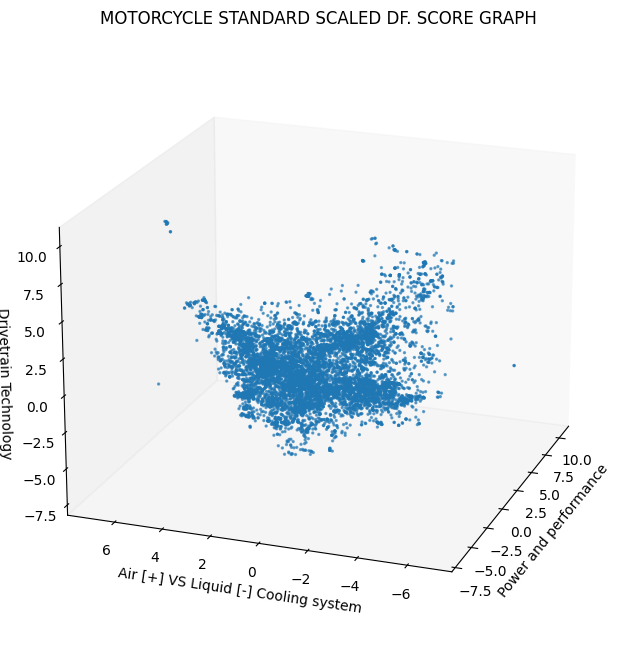

In [23]:
#StandardScaled Dataframe. ScatterPlot with all the 1st 3 PCs

fig_3d = plt.figure(figsize=(8, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(results_std[:, 0], results_std[:, 1], results_std[:, 2], s=2, alpha = 0.6)
#ax_3d.set_box_aspect((1, 1, 1))
plt.title('MOTORCYCLE STANDARD SCALED DF. SCORE GRAPH')
ax_3d.set_xlabel(pc_std_names[0])
ax_3d.set_ylabel(pc_std_names[1])
ax_3d.set_zlabel(pc_std_names[2])

ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)
# for line in ax_3d.xaxis.get_gridlines() + ax_3d.yaxis.get_gridlines() + ax_3d.zaxis.get_gridlines():
#     line.set_linestyle(':')
#     line.set_color('gray')
#     line.set_linewidth(0.5)
#     line.set_alpha(0.6)
plt.show()




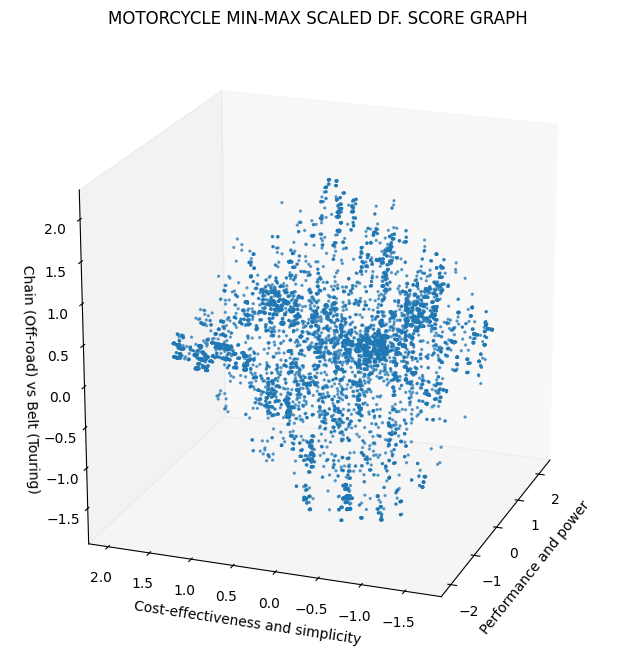

In [24]:
#Min-Max Dataframe. ScatterPlot with all the 1st 3 PCs

fig_3d = plt.figure(figsize=(8, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(results_mm[:, 0], results_mm[:, 1], results_mm[:, 2], s=2, alpha = 0.6)
ax_3d.set_box_aspect((1, 1, 1))
plt.title('MOTORCYCLE MIN-MAX SCALED DF. SCORE GRAPH')
ax_3d.set_xlabel(pc_mm_names[0])
ax_3d.set_ylabel(pc_mm_names[1])
ax_3d.set_zlabel(pc_mm_names[2])
ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()


######### here we need to complete exercise 5 #########
TO DO:
-upgrade scatter plot for STD_DF -> colors wrt category

TO DO #2: MINMAX_DF creation and same things for the STD_DF

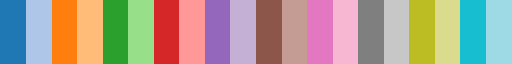

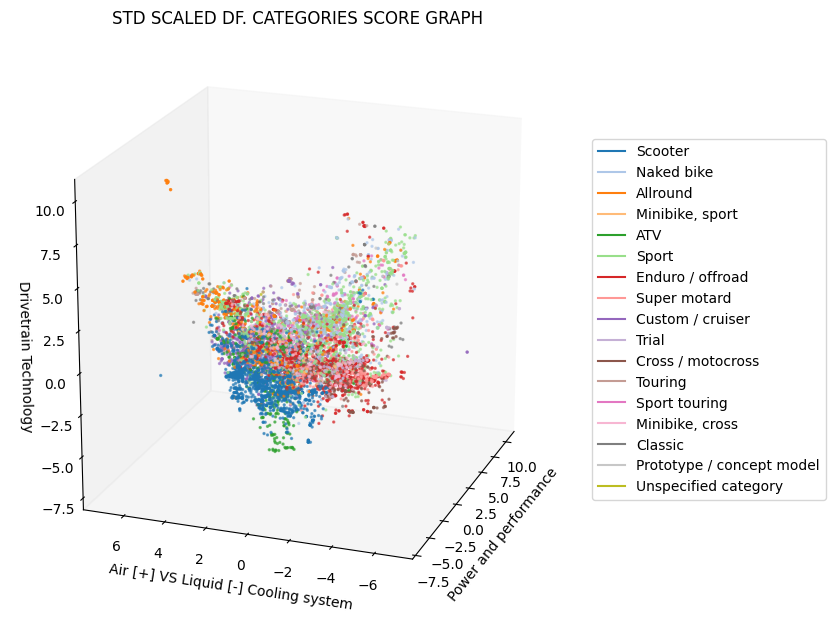

In [25]:
##### IN THIS CELL MORE SCORE GRAPHS WILL BE PLOTTED WRT BRANDS AND CATEGORIES ######

#categories plotting

colors1 = cm.tab20.colors

display(cm.tab20)

categories = LabelsDF['Category'].unique()
#brands = LabelsDF['Brand'].unique()
#print(list(brands))
#dictionary assigning a color to each category

categories_colors = {categories[i]: colors1[i] for i in range(len(categories))}
#brands_colors = {brands[i]: colors2[i] for i in range(len(brands))}

##add the color columns to the Labels DF
LabelsDF['Category Color'] = [categories_colors[i] for i in LabelsDF['Category'].values]
#LabelsDF['Brand Color'] = [brands_colors[i] for i in LabelsDF['Brand']]


#make a custom legend for colors

categories_colors_legend = [Line2D([0], [0], color=categories_colors[k]) for k in categories_colors.keys()]

#STANDARD SCALED DATAFRAME
#make the 3d colored graph
fig_3d = plt.figure(figsize=(10,10))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(results_std[:, 0], results_std[:, 1], results_std[:, 2], s=2,  c = LabelsDF['Category Color'].values, alpha = 0.6)
ax_3d.set_box_aspect((1, 1, 1))
plt.title('STD SCALED DF. CATEGORIES SCORE GRAPH')
ax_3d.set_xlabel(pc_std_names[0])
ax_3d.set_ylabel(pc_std_names[1])
ax_3d.set_zlabel(pc_std_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
ax_3d.view_init(elev=20, azim=-160)
#ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()


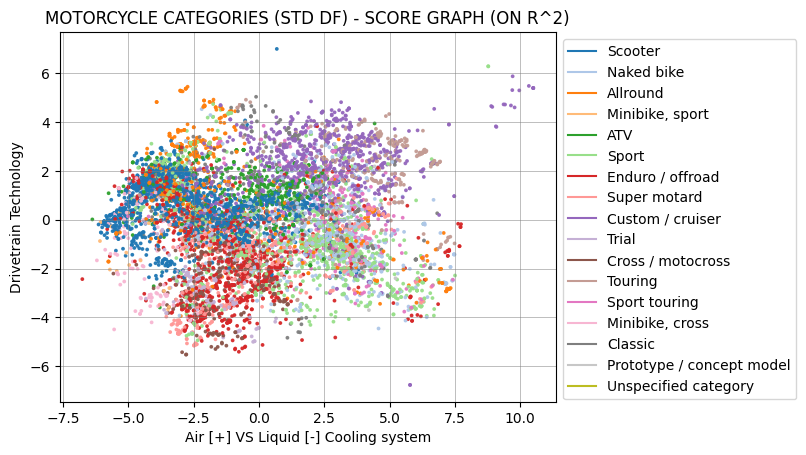

In [26]:
plt.figure()
plt.scatter(results_std[:, 0], results_std[:, 1], s=3, c=LabelsDF['Category Color'].values, alpha=0.9)
plt.title('MOTORCYCLE CATEGORIES (STD DF) - SCORE GRAPH (ON R^2)')
plt.xlabel(pc_std_names[1])
plt.ylabel(pc_std_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.show()

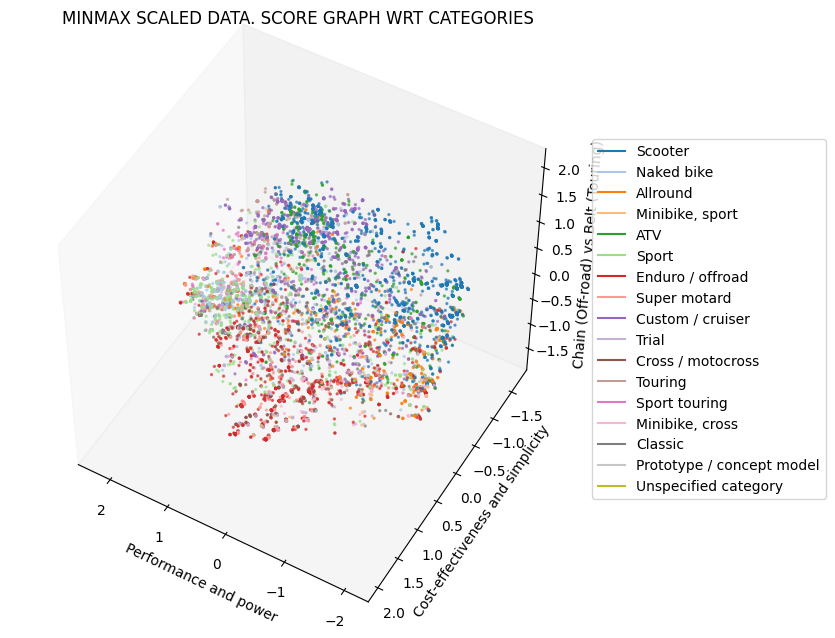

In [27]:
#MINMAX SCALED DATAFRAME
#make the 3d colored graph
fig_3d = plt.figure(figsize=(10,10))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(results_mm[:, 0], results_mm[:, 1], results_mm[:, 2], s=2,  c = LabelsDF['Category Color'].values, alpha = 0.6)
ax_3d.set_box_aspect((1, 1, 1))
plt.title('MINMAX SCALED DATA. SCORE GRAPH WRT CATEGORIES')
ax_3d.set_xlabel(pc_mm_names[0])
ax_3d.set_ylabel(pc_mm_names[1])
ax_3d.set_zlabel(pc_mm_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
ax_3d.view_init(elev=50, azim=120)
#ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()

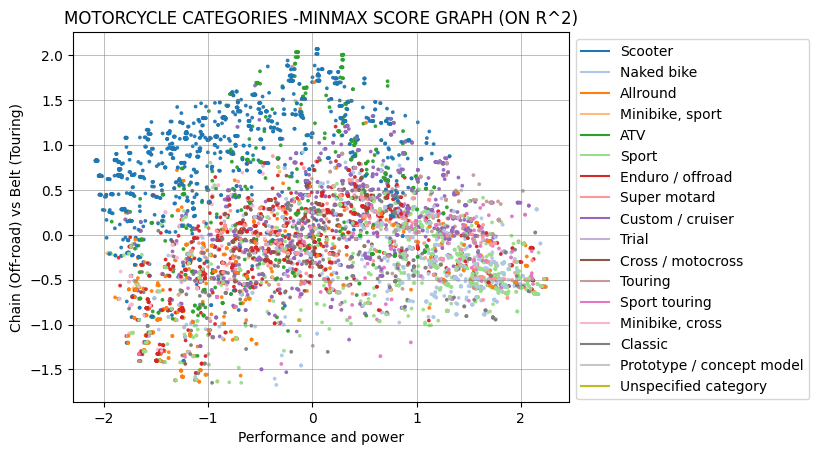

In [28]:
plt.figure()
plt.scatter(results_mm[:, 0], results_mm[:, 2], s=3, c=LabelsDF['Category Color'].values, alpha=0.9)
plt.title('MOTORCYCLE CATEGORIES -MINMAX SCORE GRAPH (ON R^2)')
plt.xlabel(pc_mm_names[0])
plt.ylabel(pc_mm_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.show()

In [29]:
#3d score graph according to the "YEAR"label. This is to show improvements made thorough the years about the first principal components

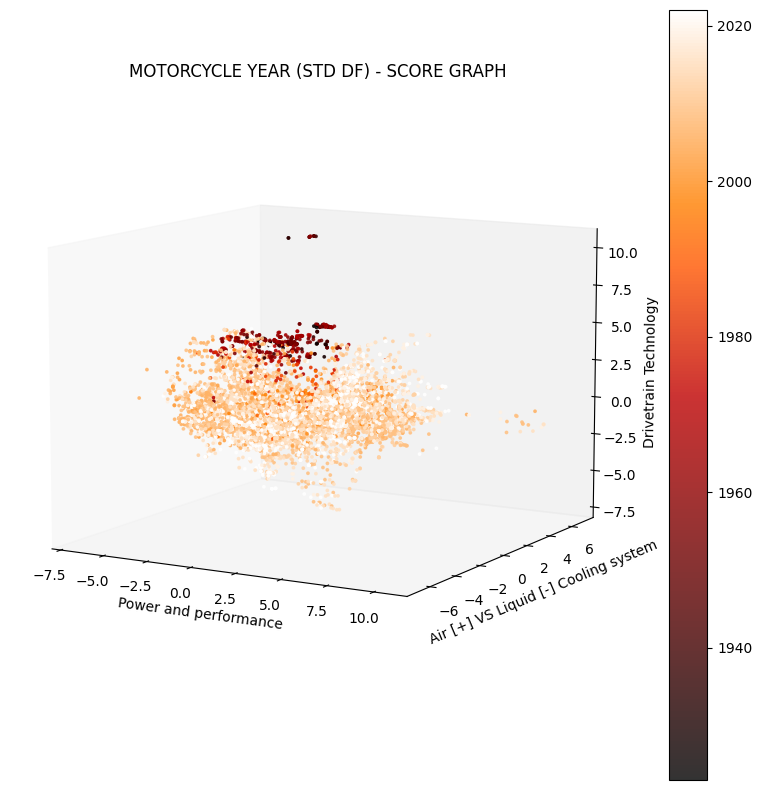

In [30]:
sg_year = plt.figure(figsize=(10,10))
ax_3d_year = sg_year.add_subplot(111, projection='3d')
year_scatter = ax_3d_year.scatter(results_std[:, 0], results_std[:, 1], results_std[:, 2], s=3, c=LabelsDF['Year'].values, cmap='gist_heat', alpha=0.8)
plt.title('MOTORCYCLE YEAR (STD DF) - SCORE GRAPH ')
ax_3d_year.set_xlabel(pc_std_names[0])
ax_3d_year.set_ylabel(pc_std_names[1])
ax_3d_year.set_zlabel(pc_std_names[2])
plt.colorbar(year_scatter)
ax_3d_year.view_init(elev=10, azim=-60)
ax_3d_year.grid(False)
plt.show()

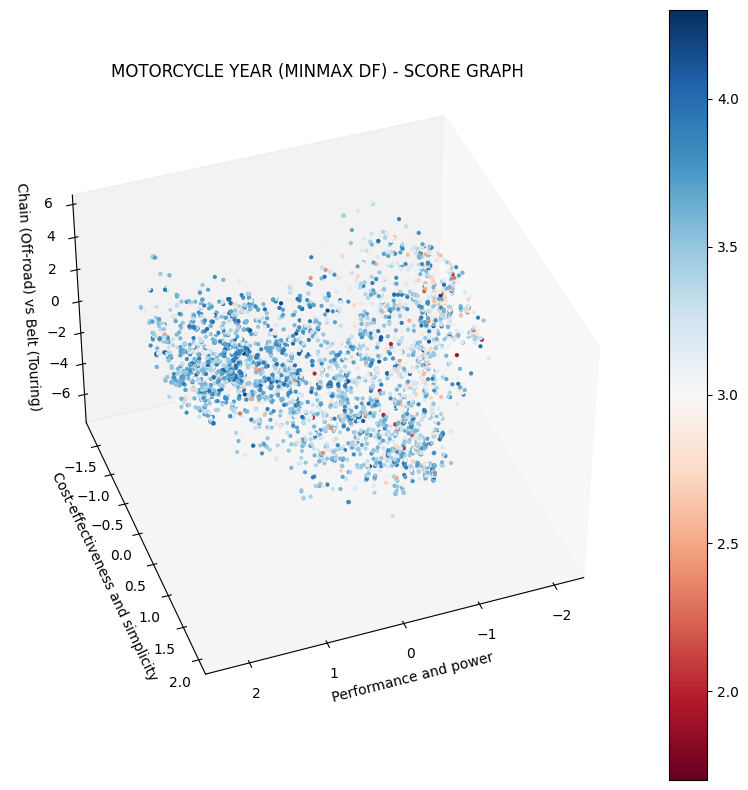

In [31]:
sg_year = plt.figure(figsize=(10,10))
ax_3d_year = sg_year.add_subplot(111, projection='3d')
year_scatter = ax_3d_year.scatter(results_mm[:, 0], results_mm[:, 1], results_std[:, 2], s=4, c=LabelsDF['Rating'].values, cmap='RdBu', alpha=1)
plt.title('MOTORCYCLE YEAR (MINMAX DF) - SCORE GRAPH ')
ax_3d_year.set_xlabel(pc_mm_names[0])
ax_3d_year.set_ylabel(pc_mm_names[1])
ax_3d_year.set_zlabel(pc_mm_names[2])
plt.colorbar(year_scatter)
ax_3d_year.view_init(elev=40, azim=70)
ax_3d_year.grid(False)
plt.show()

### Exercise 5 (k-Means)

In [32]:
#Performing k-means with k in [3,10]
km_list = []
silcoeff_list_std = []
k_list = list(range(3, 11))
# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT

print(f'KMEANS ALGORTHM ON STANDARD-SCALED DATAFRAME')
for i in range(len(k_list)):
    print(f'Computing with k={k_list[i]}...')
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
    km = km_list[i]
    km.fit(results_std)
    silcoeff_list_std.append(silhouette_score(results_std, km.labels_))
    print(f'***************')
    print('')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_std = np.argmax(silcoeff_list_std)
k_std = k_list[i_best_std]
km_std = km_list[i_best_std]

# VISUALIZE THE RESULT
print('\nRESULTS OF THE SEARCH')
print(f'Best silhouette score for StandardScaled DF: {np.max(silcoeff_list_std)} with k = {k_std}')


KMEANS ALGORTHM ON STANDARD-SCALED DATAFRAME
Computing with k=3...
***************

Computing with k=4...
***************

Computing with k=5...
***************

Computing with k=6...
***************

Computing with k=7...
***************

Computing with k=8...
***************

Computing with k=9...
***************

Computing with k=10...
***************


RESULTS OF THE SEARCH
Best silhouette score for StandardScaled DF: 0.31752837773307496 with k = 6


In [33]:
print(silcoeff_list_std)

[0.2579865635762234, 0.2816027453059682, 0.31129772560984237, 0.31752837773307496, 0.30179450609427955, 0.30790437481244426, 0.3037915620125517, 0.3028843102644041]


In [32]:
###THESE ARE THE DEFAULT PARAMETERS OF KMEANS####
#ONLY ALGORITHM IS DIFFERENT: DEFAULT IS LLOYD
#KMeans(n_clusters=8, init="k-means++", n_init="warn", max_iter=300, tol=1e-4, verbose=(), random_state=None, copy_x=True, algorithm="elkan")
#KMeans()

In [34]:
#######MIN MAX SCALED DATAFRAME########
#Performing k-means with k in [3,10]
km_list = []
silcoeff_list_mm = []
k_list = list(range(3, 11))
# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT

print(f'KMEANS ALGORTHM ON MIN-MAX-SCALED DATAFRAME')
for i in range(len(k_list)):
    print(f'k={k_list[i]}\n')
    print('Computing...')
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
    km = km_list[i]
    km.fit(results_mm)
    silcoeff_list_mm.append(silhouette_score(results_mm, km.labels_))
    print(f'***************\n')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm = np.argmax(silcoeff_list_mm)
k_mm = k_list[i_best_mm]
km_mm = km_list[i_best_mm]

# VISUALIZE THE RESULT
print('\nRESULTS OF THE SEARCH')
print(f'Best silhouette score for StandardScaled DF: {np.max(silcoeff_list_mm)} with k = {k_mm}')




KMEANS ALGORTHM ON MIN-MAX-SCALED DATAFRAME
k=3

Computing...
***************

k=4

Computing...
***************

k=5

Computing...
***************

k=6

Computing...
***************

k=7

Computing...
***************

k=8

Computing...
***************

k=9

Computing...
***************

k=10

Computing...
***************


RESULTS OF THE SEARCH
Best silhouette score for StandardScaled DF: 0.39750591825987464 with k = 4


In [61]:
#Playing with other parameters for k-means. at first let's modify the number of iterations to see when the algorithm converges
#STANDARD SCALED DATAFRAME
km_list = []
silcoeff_list_mm = []
k_list = list(range(3, 11))

print(f'KMEANS ALGORITHM ON MIN-MAX-SCALED DATAFRAME')

for n_iter in range(1, 51):
    print(f'n_iter={n_iter}')
    km_list.append([])
    silcoeff_list_mm.append([])
    for i in range(len(k_list)):
        print(f'k={k_list[i]}')
        print('Computing...')
        km_list[n_iter-1].append(KMeans(n_clusters=k_list[i], n_init=3, max_iter=n_iter, random_state=rs))
        km = km_list[n_iter-1][i]
        km.fit(results_mm)
        silcoeff_list_mm[n_iter-1].append(silhouette_score(results_mm, km.labels_))
        # print(f'n_iter={n_iter}, k={k_list[i]}, n_iter_={km.n_iter_}, sil_score={silcoeff_list_mm[n_iter-1][-1]}')
        # print('***************')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm, j_best_mm = np.unravel_index(np.argmax(silcoeff_list_mm), np.shape(silcoeff_list_mm))
k_mm = k_list[i_best_mm]
n_iter_mm = j_best_mm + 1
km_mm = km_list[n_iter_mm-1][i_best_mm]

# VISUALIZE THE RESULT
print('\nRESULTS OF THE SEARCH')
print(f'Best silhouette score for Min-Max Scaled DF: {np.max(silcoeff_list_mm)} with k={k_mm}, n_iter={n_iter_mm}, and n_iter_={km_mm.n_iter_}')



KMEANS ALGORITHM ON MIN-MAX-SCALED DATAFRAME
n_iter=1
k=3
Computing...
k=4
Computing...
k=5
Computing...
k=6
Computing...
k=7
Computing...
k=8
Computing...
k=9
Computing...
k=10
Computing...
n_iter=2
k=3
Computing...
k=4
Computing...
k=5
Computing...
k=6
Computing...
k=7
Computing...
k=8
Computing...
k=9
Computing...
k=10
Computing...
n_iter=3
k=3
Computing...
k=4
Computing...
k=5
Computing...
k=6
Computing...
k=7
Computing...
k=8
Computing...
k=9
Computing...
k=10
Computing...
n_iter=4
k=3
Computing...
k=4
Computing...
k=5
Computing...
k=6
Computing...
k=7
Computing...
k=8
Computing...
k=9
Computing...
k=10
Computing...
n_iter=5
k=3
Computing...
k=4
Computing...
k=5
Computing...
k=6
Computing...
k=7
Computing...
k=8
Computing...
k=9
Computing...
k=10
Computing...
n_iter=6
k=3
Computing...
k=4
Computing...
k=5
Computing...
k=6
Computing...
k=7
Computing...
k=8
Computing...
k=9
Computing...
k=10
Computing...
n_iter=7
k=3
Computing...
k=4
Computing...
k=5
Computing...
k=6
Computing...
k=

n_iter=1
n_iter=2
n_iter=3
n_iter=4
n_iter=5
n_iter=6
n_iter=7
n_iter=8
n_iter=9
n_iter=10
n_iter=11
n_iter=12
n_iter=13
n_iter=14
n_iter=15
n_iter=16
n_iter=17
n_iter=18
n_iter=19
n_iter=20
n_iter=21
n_iter=22
n_iter=23
n_iter=24
n_iter=25
n_iter=26
n_iter=27
n_iter=28
n_iter=29
n_iter=30
n_iter=31
n_iter=32
n_iter=33
n_iter=34
n_iter=35
n_iter=36
n_iter=37
n_iter=38
n_iter=39
n_iter=40
n_iter=41
n_iter=42
n_iter=43
n_iter=44
n_iter=45
n_iter=46
n_iter=47
n_iter=48
n_iter=49
n_iter=50


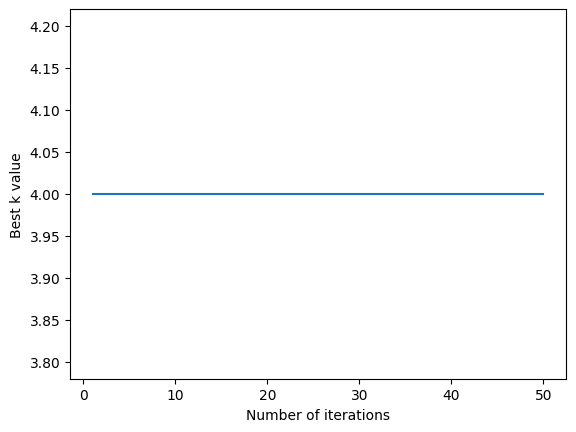

In [69]:

# define the range of k and n_iter values to test
k_list = list(range(3, 11))
n_iter_list = list(range(1, 51))

# create empty arrays to store the silhouette scores and best k values
silhouette_scores = np.zeros((len(k_list), len(n_iter_list)))
best_k_values = np.zeros(len(n_iter_list))

# loop over the n_iter values
for j, n_iter in enumerate(n_iter_list):
    print(f'n_iter={n_iter}')
    sil_scores = []
    k_values = []
    # loop over the k values
    for i, k in enumerate(k_list):
        km = KMeans(n_clusters=k, n_init=3, max_iter=n_iter, random_state=0)
        km.fit(results_mm)
        sil_score = silhouette_score(results_mm, km.labels_)
        sil_scores.append(sil_score)
        k_values.append(k)
    silhouette_scores[:, j] = sil_scores
    i_best = np.argmax(sil_scores)
    best_k_values[j] = k_values[i_best]

# plot the best k values for each n_iter
plt.plot(n_iter_list, best_k_values)
plt.xlabel('Number of iterations')
plt.ylabel('Best k value')
plt.show()
